In this notebook we analyse the regret for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

To measure regret, we use a policy learned with full reward information each time step.

The measure of comparison is the average return over all runs at the final episode $K_{max}$, $G_{avg,K_{max}} = \frac{1}{K_{max}}\sum^{K_{max}}_{K=1} G_{k}$.

Then we average that across runs, and compute the returns ratio as: $\frac{\mu_{\bar{G}^{m}_{K}} - \mu_{\bar{G}^{FR}_{K}}}{\vert \mu_{\bar{G}^{FR}_{K}} \rvert}$.
It tells us the percentage difference in average return between the policy trained with algorithm $m$ compared to the full rewards policy.
Lower is better.

Key on methods:

  - "PP/FR": Full rewards information
  - "PP/IMR": Impute missing rewards (zero when absent)
  - "PP/LEAST-LFA": Reward estimation
  - "OP-A/FR": Options policy, with composition actions as options
  - "OP-S/FR": Options policy, with repeated single action as options

In [1]:
import copy
import os
import pathlib
from typing import Set
import itertools

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats

In [3]:
import matplotlib
from matplotlib import pyplot as plt

In [4]:
from drmdp import dataproc

In [5]:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [6]:
import warnings  # To suppress some warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [7]:
files = tf.io.gfile.glob(
    f"{pathlib.Path.home()}/fs/drmdp/workflows/controljob/agg/1763120034/1763137330/metrics/*.parquet"
)

In [8]:
df_metrics = dataproc.read_data(files, reader="pd")

In [9]:
df_metrics

,episode,exp_id,meta,returns,steps,metrics,method
0,250,1763120034-0541946b-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1166.9694295443726, 1821.786532668395, 1279.3...","[2135, 1038, 980, 687, 1031, 1456, 668, 1973, ...","{'returns': {'mean': 1590.8574759418373, 'std'...",FR
1,250,1763120034-078ace44-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1233.9993188066744, 1226.0556551239783, 911.4...","[207, 72, 45, 663, 364, 1356, 1958, 436, 70, 9...","{'returns': {'mean': 1205.6348442049234, 'std'...",BLADE-TD
2,250,1763120034-0f495b0d-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[18194.995057068074, 18930.775810710056, 18965...","[10000, 10000, 10000, 10000, 10000, 10000, 100...","{'returns': {'mean': 18143.385609982528, 'std'...",DMR
3,250,1763120034-03297052-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[18927.069956467905, 18822.31747040419, 18976....","[10000, 10000, 10000, 10000, 10000, 10000, 100...","{'returns': {'mean': 18275.500267493597, 'std'...",DMR
4,250,1763120034-0a5b9c15-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1315.1223026231526, 1236.6400844641971, 1317....","[191, 702, 580, 1660, 263, 350, 314, 3009, 228...","{'returns': {'mean': 1342.2280210041272, 'std'...",FR
...,...,...,...,...,...,...,...
247,420,1763120034-d100f64b-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1087.091855966162, 2854.354725581369, 4414.51...","[222, 3602, 10000, 4265, 3816, 7890, 2814, 100...","{'returns': {'mean': 2815.5111304651336, 'std'...",BLADE-TD[N-B]
248,420,1763120034-f6d7bba7-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1065.4797525546705, 1038.6901546594227, 1044....","[427, 849, 68, 1855, 1139, 328, 845, 1025, 14,...","{'returns': {'mean': 976.4654795174813, 'std':...",IMR
249,420,1763120034-f87b4ef1-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[12878.428296760741, 16332.928597073538, 12213...","[10000, 10000, 10000, 10000, 10000, 10000, 100...","{'returns': {'mean': 14379.725729830892, 'std'...",BLADE-TD
250,420,1763120034-fbc639af-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[16119.556191530583, 16396.892585095524, 16631...","[10000, 10000, 10000, 535, 10000, 1608, 10000,...","{'returns': {'mean': 14640.848488118598, 'std'...",BLADE-TD[N-B]


In [10]:
df_metrics.iloc[0]["meta"]

{'context': {'dummy': 0},
 'exp_id': '1763120034-0541946b-Finite-TC-ShuntDc-v0',
 'instance_id': 14,
 'run_config': {'episodes_per_run': 500,
  'log_episode_frequency': 10,
  'num_runs': 20,
  'output_dir': 'gs://mo-hendrix-ml-workflows-storage/drmdp/workflows/controljob/logs/1763120034/1763120034-0541946b-Finite-TC-ShuntDc-v0/run_14/identity/a43ec355',
  'use_seed': True},
 'env_spec': {'args': {'constraint_violation_reward': -10.0,
   'emit_state': True,
   'max_episode_steps': 10000,
   'penalty_gamma': 1.0,
   'reward_fn': 'pos-enf'},
  'feats_spec': {'args': None, 'name': 'scale'},
  'name': 'Finite-TC-ShuntDc-v0'},
 'epochs': 1,
 'problem_spec': {'delay_config': None,
  'epsilon': 0.1,
  'gamma': 0.99,
  'learning_rate_config': {'args': {'initial_lr': 0.01}, 'name': 'constant'},
  'policy_type': 'markovian',
  'reward_mapper': {'args': None, 'name': 'identity'}},
 'reward_mapper': 'FR',
 'policy_type': 'PP'}

In [11]:
df_metrics

,episode,exp_id,meta,returns,steps,metrics,method
0,250,1763120034-0541946b-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1166.9694295443726, 1821.786532668395, 1279.3...","[2135, 1038, 980, 687, 1031, 1456, 668, 1973, ...","{'returns': {'mean': 1590.8574759418373, 'std'...",FR
1,250,1763120034-078ace44-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1233.9993188066744, 1226.0556551239783, 911.4...","[207, 72, 45, 663, 364, 1356, 1958, 436, 70, 9...","{'returns': {'mean': 1205.6348442049234, 'std'...",BLADE-TD
2,250,1763120034-0f495b0d-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[18194.995057068074, 18930.775810710056, 18965...","[10000, 10000, 10000, 10000, 10000, 10000, 100...","{'returns': {'mean': 18143.385609982528, 'std'...",DMR
3,250,1763120034-03297052-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[18927.069956467905, 18822.31747040419, 18976....","[10000, 10000, 10000, 10000, 10000, 10000, 100...","{'returns': {'mean': 18275.500267493597, 'std'...",DMR
4,250,1763120034-0a5b9c15-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1315.1223026231526, 1236.6400844641971, 1317....","[191, 702, 580, 1660, 263, 350, 314, 3009, 228...","{'returns': {'mean': 1342.2280210041272, 'std'...",FR
...,...,...,...,...,...,...,...
247,420,1763120034-d100f64b-Finite-TC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1087.091855966162, 2854.354725581369, 4414.51...","[222, 3602, 10000, 4265, 3816, 7890, 2814, 100...","{'returns': {'mean': 2815.5111304651336, 'std'...",BLADE-TD[N-B]
248,420,1763120034-f6d7bba7-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[1065.4797525546705, 1038.6901546594227, 1044....","[427, 849, 68, 1855, 1139, 328, 845, 1025, 14,...","{'returns': {'mean': 976.4654795174813, 'std':...",IMR
249,420,1763120034-f87b4ef1-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[12878.428296760741, 16332.928597073538, 12213...","[10000, 10000, 10000, 10000, 10000, 10000, 100...","{'returns': {'mean': 14379.725729830892, 'std'...",BLADE-TD
250,420,1763120034-fbc639af-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[16119.556191530583, 16396.892585095524, 16631...","[10000, 10000, 10000, 535, 10000, 1608, 10000,...","{'returns': {'mean': 14640.848488118598, 'std'...",BLADE-TD[N-B]


In [12]:
envs = dataproc.get_distinct_envs(df_metrics)

In [13]:
envs

{'Finite-TC-ShuntDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': True,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-SC-PermExDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-ShuntDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-TC-PermExDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-CC-PermExDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': False,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'Finite-SC-ShuntDc-v0': {'constraint_violation_reward': -10.0,
  'emit_state': True,
  'max_episode_steps': 10000,
  'penalty_gamma': 1.0,
  'reward_fn': 'po

In [14]:
METHODS = sorted(df_metrics["method"].unique())

In [15]:
METHODS

['BLADE-TD', 'BLADE-TD[N-B]', 'DMR', 'FR', 'IMR', 'OP-A']

In [16]:
def parse_delay_config(df_input: pd.DataFrame):
    df = copy.deepcopy(df_input)

    def parse_mu(delay_config):
        if delay_config is None:
            return None
        args = delay_config["args"]
        try:
            return args["delay"]
        except KeyError:
            return args["lam"]
        except KeyError as exc:
            raise ValueError(f"Unknown delay config {args}") from exc

    df["delay_type"] = df["delay_config"].apply(lambda dc: dc["name"] if dc else None)
    df["delay_mu"] = df["delay_config"].apply(parse_mu)
    del df["delay_config"]
    return df

In [17]:
def max_episode_filter(df_input):
    env_spec = df_input["meta"].apply(lambda meta: meta["env_spec"])
    env_name = env_spec.apply(lambda spec: spec["name"])
    envs = env_name.unique()
    dfs = []
    for env in envs:
        df_slice = df_input[(env_name == env)]
        df_slice = df_slice[df_slice["episode"] == df_slice["episode"].max()]
        dfs.append(copy.deepcopy(df_slice))
    return pd.concat(dfs)

In [18]:
def extract_salient_meta_fields(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data)

    specs = {
        "env": df_raw["meta"].apply(lambda meta: meta["env_spec"]),
        "feats": df_raw["meta"].apply(lambda meta: meta["env_spec"]["feats_spec"]),
    }

    for prefix, col_fam in specs.items():
        for col in ("name", "args"):
            df_raw[f"{prefix}_{col}"] = col_fam.apply(lambda spec: spec[col])

    for key in (
        "delay_config",
        "gamma",
    ):
        df_raw[key] = df_raw["meta"].apply(lambda meta: meta["problem_spec"][key])
    return parse_delay_config(df_raw)

## Regret - Relative to full rewards observation

In [19]:
def calculate_regret_over_configurations(df_data):
    def calc_regret(y_pred, y_oracle):
        # agg returns
        mean_y_oracle = np.mean(y_oracle)
        return (np.mean(y_pred) - mean_y_oracle) / np.abs(mean_y_oracle)

    df_result = max_episode_filter(df_data)
    df_result = extract_salient_meta_fields(df_result)

    df_baseline = df_result[pd.isnull(df_result["delay_type"])]
    df_result = df_result[~pd.isnull(df_result["delay_type"])]

    baselines = {}
    keys = ["env_name", "gamma", "delay_config"]
    for row in df_baseline.to_dict("records"):
        key = tuple(row[key] for key in keys[:-1])
        baselines[key] = row["returns"]

    for key in sorted(baselines.keys()):
        print(key)

    rows = []
    for row in df_result.to_dict("records"):
        key = tuple([row[key] for key in keys[:-1]])
        full_reward_mean_return = baselines[key]
        regret = calc_regret(y_pred=row["returns"], y_oracle=full_reward_mean_return)
        row["relative_regret"] = regret
        row["method"] = row["method"]
        rows.append(row)

    df_regret = pd.DataFrame(rows)
    df_regret = df_regret[
        ["env_name", "method", "delay_type", "delay_mu", "relative_regret"]
    ].sort_values(["env_name", "method", "delay_type", "delay_mu"])
    return {"sarsa": df_regret}

In [20]:
METHODS_PALETTES = {
    key: palette for key, palette in zip(dataproc.ORDERED_METHODS, sns.color_palette())
}

In [21]:
METHODS_PALETTES

{'BLADE-TD': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'BLADE-TD[N-B]': (1.0, 0.4980392156862745, 0.054901960784313725),
 'IMR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'OP-A': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'OP-S': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'DMR': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'FR': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

In [22]:
def plot_regret(
    df_data, suffix=None, method_filter_fn=lambda met: True, output_dir="figures/regret"
):
    df_raw = copy.deepcopy(
        df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]]
    )
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    rps = sorted(df_raw["delay_mu"].unique())

    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(rps),
        figsize=(4 * len(rps), 4),
        sharey=False,
    )

    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["delay_mu"] == rp]
        sns.boxplot(
            df_plot,
            x="env_name",
            y="relative_regret",
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns Ratio")
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(len(rps) / 2.0, 1.3),
                ncol=3,
                fancybox=True,
            )
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches="tight")

In [23]:
dfs_regret = calculate_regret_over_configurations(df_metrics)

('Finite-CC-PermExDc-v0', 0.99)
('Finite-CC-PermExDc-v0', 1.0)
('Finite-CC-ShuntDc-v0', 0.99)
('Finite-CC-ShuntDc-v0', 1.0)
('Finite-SC-PermExDc-v0', 0.99)
('Finite-SC-PermExDc-v0', 1.0)
('Finite-SC-ShuntDc-v0', 0.99)
('Finite-SC-ShuntDc-v0', 1.0)
('Finite-TC-PermExDc-v0', 0.99)
('Finite-TC-PermExDc-v0', 1.0)
('Finite-TC-ShuntDc-v0', 0.99)
('Finite-TC-ShuntDc-v0', 1.0)


In [24]:
dfs_regret["sarsa"]

,env_name,method,delay_type,delay_mu,relative_regret
146,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,2.0,-0.035648
157,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,2.0,-0.030373
160,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,4.0,0.039881
162,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,4.0,0.009547
161,Finite-CC-PermExDc-v0,BLADE-TD,clipped-poisson,6.0,0.051939
...,...,...,...,...,...
15,Finite-TC-ShuntDc-v0,IMR,clipped-poisson,8.0,-0.418892
18,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,2.0,-0.905227
20,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,2.0,-0.985098
21,Finite-TC-ShuntDc-v0,OP-A,clipped-poisson,4.0,-0.979058


In [25]:
dfs_regret["sarsa"]["env_name"].unique()

array(['Finite-CC-PermExDc-v0', 'Finite-CC-ShuntDc-v0',
       'Finite-SC-PermExDc-v0', 'Finite-SC-ShuntDc-v0',
       'Finite-TC-PermExDc-v0', 'Finite-TC-ShuntDc-v0'], dtype=object)

In [26]:
sorted(dfs_regret["sarsa"]["delay_mu"].unique())

[2.0, 4.0, 6.0, 8.0]

In [27]:
dfs_regret["sarsa"].dtypes

env_name            object
method              object
delay_type          object
delay_mu           float64
relative_regret    float64
dtype: object

In [28]:
def filter_envs(df_input, envs: Set[str]):
    mask = df_input["env_name"].apply(lambda name: name in envs)
    return copy.copy(df_input[mask])

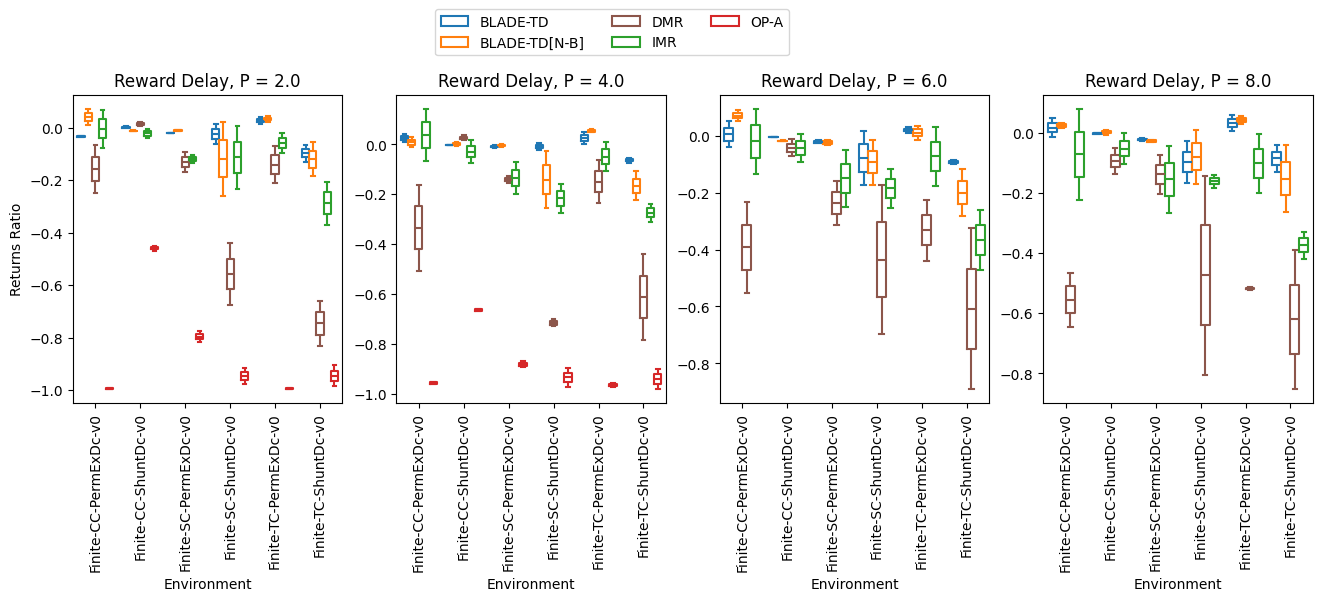

In [29]:
plot_regret(dfs_regret["sarsa"], suffix="sarsa")

## Proc Data: Run Return Matrix

For the next metrics, we need a matrix where each run is is a row, and the columns represent returns at each episode.

In [30]:
def calc_runs_returns_matrix(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(
        df_data[["episode", "exp_id", "returns", "steps", "meta", "method"]]
    )

    rows = []
    experiments = df_metrics["exp_id"].unique()
    for exp_id in experiments:
        df_exp = df_raw[df_raw["exp_id"] == exp_id]
        example = df_exp.iloc[0]
        # get episodes time series
        episodes = np.array(df_exp["episode"].values)
        # matrix of return (rows) x run (columns)
        returns = np.stack(df_exp["returns"].values)
        steps = np.stack(df_exp["steps"].values)
        # sort episodes
        sorting_indices = np.argsort(episodes)
        # reorder returns by episode - earliest to latest
        sorted_returns = returns[sorting_indices, :]
        sorted_steps = steps[sorting_indices, :]
        # transpose matrix to run (rows) x return (columns)
        runs_returns_matrix = np.transpose(sorted_returns)
        runs_steps_matrix = np.transpose(sorted_steps)
        rows.append(
            {
                "exp_id": exp_id,
                "runs_returns_matrix": runs_returns_matrix,
                "runs_steps_matrix": runs_steps_matrix,
                "env_name": example["meta"]["env_spec"]["name"],
                "gamma": example["meta"]["problem_spec"]["gamma"],
                "delay_config": example["meta"]["problem_spec"]["delay_config"],
                "method": example["method"],
                "meta": example["meta"],
                "episodes": np.array(sorted(episodes)),
            }
        )
    return parse_delay_config(pd.DataFrame(rows))

In [31]:
%%time
df_runs_returns = calc_runs_returns_matrix(df_metrics)

CPU times: user 190 ms, sys: 5.38 ms, total: 195 ms
Wall time: 152 ms


In [32]:
df_runs_returns

,exp_id,runs_returns_matrix,runs_steps_matrix,env_name,gamma,method,meta,episodes,delay_type,delay_mu
0,1763120034-0541946b-Finite-TC-ShuntDc-v0,"[[5.232413635195506, 4.687840819249332, 2060.7...","[[8, 7, 845, 842, 212, 678, 6994, 26, 1300, 62...",Finite-TC-ShuntDc-v0,0.99,FR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",None,NaN
1,1763120034-078ace44-Finite-SC-PermExDc-v0,"[[19.01418569316258, 2749.334785113375, 1469.6...","[[17, 114, 9, 885, 877, 2992, 59, 536, 7, 1738...",Finite-SC-PermExDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0
2,1763120034-0f495b0d-Finite-CC-ShuntDc-v0,"[[18897.154275046858, 5.526600685996535, 17869...","[[10000, 7, 10000, 10000, 10000, 10000, 10000,...",Finite-CC-ShuntDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0
3,1763120034-03297052-Finite-CC-ShuntDc-v0,"[[18740.864737448857, 6134.31168520065, 17863....","[[10000, 1009, 10000, 10000, 10000, 10000, 100...",Finite-CC-ShuntDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
4,1763120034-0a5b9c15-Finite-SC-PermExDc-v0,"[[11514.94118981567, 3059.5857221405836, 249.2...","[[6148, 1477, 9, 250, 6468, 972, 40, 2284, 292...",Finite-SC-PermExDc-v0,1.00,FR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",None,NaN
...,...,...,...,...,...,...,...,...,...,...
223,1763120034-d100f64b-Finite-TC-ShuntDc-v0,"[[20.46711827180718, 2961.951498806046, 4.6377...","[[16, 664, 7, 8, 7, 7, 231, 344, 679, 427, 997...",Finite-TC-ShuntDc-v0,0.99,BLADE-TD[N-B],"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
224,1763120034-f6d7bba7-Finite-SC-PermExDc-v0,"[[15.925128771160031, 1774.9190045571997, 1455...","[[15, 516, 1869, 556, 1209, 1092, 300, 269, 37...",Finite-SC-PermExDc-v0,0.99,IMR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0
225,1763120034-f87b4ef1-Finite-TC-PermExDc-v0,"[[37.870610892730156, 86.88137940749344, 202.3...","[[27, 12, 47, 10000, 10000, 1978, 10000, 5371,...",Finite-TC-PermExDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0
226,1763120034-fbc639af-Finite-TC-PermExDc-v0,"[[76.55466876756819, 18.281835674579256, 40.14...","[[51, 15, 99, 10000, 16, 537, 219, 10000, 1000...",Finite-TC-PermExDc-v0,0.99,BLADE-TD[N-B],"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,8.0


In [33]:
np.stack(df_runs_returns.iloc[0]["runs_returns_matrix"])[:2, :]

array([[5.23241364e+00, 4.68784082e+00, 2.06078964e+03, 1.84341726e+03,
        1.51492433e+03, 1.49658581e+03, 2.22930528e+02, 1.49894196e+01,
        1.45213401e+03, 1.33514474e+03, 6.41715180e+02, 1.54762289e+03,
        4.61608965e+02, 5.03968980e+02, 5.29554877e+02, 3.30605636e+02,
        6.37748392e+02, 4.89858635e+02, 4.45837682e+02, 1.75244387e+03,
        1.70301091e+03, 1.02018770e+03, 1.78679490e+03, 1.05219963e+03,
        1.83318142e+03, 1.16696943e+03, 7.80818936e+02, 1.31181362e+03,
        8.48011715e+02, 8.69193437e+02, 2.61791124e+03, 9.05456667e+02,
        9.67963330e+02, 1.44618813e+03, 3.32938592e+03, 1.00286274e+03,
        1.10391380e+03, 3.76485575e+03, 3.78472475e+03, 4.26503609e+03,
        4.05839177e+03, 2.81688226e+03, 4.88508756e+03, 4.48357871e+03,
        2.90150022e+03, 4.93483015e+03, 1.40426894e+03, 1.67771469e+03,
        6.00861733e+03, 3.55279149e+03],
       [9.02740803e+03, 2.96849518e+03, 2.14560220e+03, 4.29515598e+00,
        1.69797014e+03,

In [34]:
np.stack(df_runs_returns.iloc[0]["runs_steps_matrix"])[:2, :]

array([[    8,     7,   845,   842,   212,   678,  6994,    26,  1300,
          629,   571,   758,   648,   526,   375,   347,   454,   772,
         1138,  1011,   906,   707,   685,   787,   175,  2135,   768,
          983,   617,   577,  8562,  1166,  1285,  1007,  8575,   713,
          750,  3518,  4503,  5551,  4849,  7951, 10000,  2066,  6601,
          214,  3138,  8535,  5802,    48],
       [ 4689,  1563,   617,     7,   611,     7,   537,   630,   547,
          227,   119,   264,   428,   650,   997,   919,   590,   427,
          828,   727,  4561,  1090,   913,   828,   600,  1038,  1805,
         1099,   983,  1209,   244,  7085,   507,   321,   276,  1940,
         2443,  3780,  3473,  3892,  6350,   347,  1285,  1730, 10000,
          747,   180,  8212,  8158, 10000]])

In [35]:
def calc_ci(xs, confidence: float, method: str = "auto"):
    if method not in ("auto", "t-distribution", "normal"):
        raise ValueError("Method must be one of: {auto, t-distribution, normal}")

    # calculate mean
    mean = np.mean(xs)
    # standard error
    std_err = stats.sem(xs)

    if (method == "auto" and len(xs) < 30) or method == "t-distribution":
        form = "t-distribution"
        lb, ub = stats.t.interval(
            confidence=confidence, df=len(xs) - 1, loc=mean, scale=std_err
        )
    else:
        form = "normal"
        lb, ub = stats.norm.interval(confidence=confidence, loc=mean, scale=std_err)

    ci = np.abs(ub - mean)
    return {"ub": ub, "lb": lb, "mean": mean, "ci": ci, "ci_method": form}

In [36]:
def calc_and_format_ci(xs, confidence: float, decimals: int):
    xs = xs[~np.isnan(xs)]
    if len(xs) == 0:
        xs = [np.nan]
    ci_result = calc_ci(xs, confidence=confidence, method="auto")
    ci_fmt = " ± ".join(
        [
            str(np.around(ci_result["mean"], decimals)),
            str(np.around(ci_result["ci"], decimals)),
        ]
    )
    return ci_result, ci_fmt

In [37]:
def calc_env_method_returns_ci(
    df_results: pd.DataFrame, confidence: float, decimals: int = 4
) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["method"].unique())

    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) & (df_results["method"] == method)
            ]
        )

        # across delays, gamma, and runs
        # shape: config x run x episodes
        returns_matrix = np.stack(df_slice["runs_returns_matrix"].values)
        # take last episode
        returns_matrix = returns_matrix[:, :, -1]
        returns = returns_matrix.flatten()
        ci_result, ci_fmt = calc_and_format_ci(
            returns, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "method"])

In [38]:
calc_env_method_returns_ci(df_runs_returns, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)[["FR", "BLADE-TD", "BLADE-TD[N-B]", "IMR", "OP-A", "DMR"]]

method,FR,BLADE-TD,BLADE-TD[N-B],IMR,OP-A,DMR
env_name,,,,,,
Finite-CC-PermExDc-v0,12397.5933 ± 694.3353,12444.4817 ± 430.5246,12853.9673 ± 410.5008,12032.5303 ± 298.8156,305.0051 ± 60.779,7732.306 ± 903.7155
Finite-CC-ShuntDc-v0,18070.7939 ± 219.8873,18030.0545 ± 97.8014,17946.2695 ± 105.4386,17399.5464 ± 125.8119,7910.714 ± 410.3264,17636.4009 ± 521.0412
Finite-SC-PermExDc-v0,1253.0729 ± 15.0744,1230.6983 ± 11.9514,1232.1375 ± 10.9829,1080.1561 ± 25.4872,201.5421 ± 18.0706,1051.5118 ± 65.0412
Finite-SC-ShuntDc-v0,2087.21 ± 304.4543,1929.5857 ± 134.7077,1765.6889 ± 120.7991,1758.0627 ± 232.9472,95.6263 ± 6.7127,785.7415 ± 106.7832
Finite-TC-PermExDc-v0,12701.0206 ± 662.2372,13010.2786 ± 340.6195,13123.8988 ± 324.9859,11675.3564 ± 258.3813,253.4742 ± 49.546,8966.2785 ± 668.3316
Finite-TC-ShuntDc-v0,3162.499 ± 663.5361,2891.7606 ± 298.4667,2519.1328 ± 267.2202,2013.913 ± 291.9475,112.5899 ± 8.9317,780.6484 ± 114.3867


In [39]:
print(
    calc_env_method_returns_ci(
        df_runs_returns[
            df_runs_returns["method"].apply(lambda met: met not in set(["FR"]))
        ],
        confidence=0.95,
    )
    .pivot(columns="method", index="env_name", values="ci_fmt")[
        reversed(["BLADE-TD", "IMR", "OP-A", "DMR"])
    ]
    .to_latex()
)

\begin{tabular}{lllll}
\toprule
method & DMR & OP-A & IMR & BLADE-TD \\
env_name &  &  &  &  \\
\midrule
Finite-CC-PermExDc-v0 & 7732.306 ± 903.7155 & 305.0051 ± 60.779 & 12032.5303 ± 298.8156 & 12444.4817 ± 430.5246 \\
Finite-CC-ShuntDc-v0 & 17636.4009 ± 521.0412 & 7910.714 ± 410.3264 & 17399.5464 ± 125.8119 & 18030.0545 ± 97.8014 \\
Finite-SC-PermExDc-v0 & 1051.5118 ± 65.0412 & 201.5421 ± 18.0706 & 1080.1561 ± 25.4872 & 1230.6983 ± 11.9514 \\
Finite-SC-ShuntDc-v0 & 785.7415 ± 106.7832 & 95.6263 ± 6.7127 & 1758.0627 ± 232.9472 & 1929.5857 ± 134.7077 \\
Finite-TC-PermExDc-v0 & 8966.2785 ± 668.3316 & 253.4742 ± 49.546 & 11675.3564 ± 258.3813 & 13010.2786 ± 340.6195 \\
Finite-TC-ShuntDc-v0 & 780.6484 ± 114.3867 & 112.5899 ± 8.9317 & 2013.913 ± 291.9475 & 2891.7606 ± 298.4667 \\
\bottomrule
\end{tabular}



## Returns AUC

In [40]:
def calc_returns_auc(df_data: pd.DataFrame):
    def calc_auc(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        timesteps = np.arange(runs_returns_matrix.shape[1])
        return np.trapz(runs_returns_matrix, x=timesteps, axis=1)

    df_raw = copy.deepcopy(df_data[["exp_id", "runs_returns_matrix", "meta", "method"]])
    df_raw["auc"] = df_raw["runs_returns_matrix"].apply(calc_auc)
    df_raw = extract_salient_meta_fields(df_raw)
    del df_raw["runs_returns_matrix"]
    del df_raw["meta"]
    return df_raw

In [41]:
df_returns_auc = calc_returns_auc(df_runs_returns)

In [42]:
df_returns_auc

,exp_id,method,auc,env_name,env_args,feats_name,feats_args,gamma,delay_type,delay_mu
0,1763120034-0541946b-Finite-TC-ShuntDc-v0,FR,"[87796.93238296891, 96419.34519034004, 81631.7...",Finite-TC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,0.99,None,NaN
1,1763120034-078ace44-Finite-SC-PermExDc-v0,BLADE-TD,"[60093.42895006707, 64266.10822561817, 54607.0...",Finite-SC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",spliced-tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,6.0
2,1763120034-0f495b0d-Finite-CC-ShuntDc-v0,DMR,"[876598.6117716748, 846813.2268129988, 869049....",Finite-CC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,2.0
3,1763120034-03297052-Finite-CC-ShuntDc-v0,DMR,"[899784.4099506804, 877618.2350353848, 898209....",Finite-CC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,4.0
4,1763120034-0a5b9c15-Finite-SC-PermExDc-v0,FR,"[74131.2987356087, 79979.92509723928, 75505.11...",Finite-SC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",spliced-tiles,{'tiling_dim': 3.0},1.00,None,NaN
...,...,...,...,...,...,...,...,...,...,...
223,1763120034-d100f64b-Finite-TC-ShuntDc-v0,BLADE-TD[N-B],"[85885.85754369182, 83508.13310493159, 84354.8...",Finite-TC-ShuntDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",scale,None,0.99,clipped-poisson,4.0
224,1763120034-f6d7bba7-Finite-SC-PermExDc-v0,IMR,"[48549.50708459677, 53392.82148873113, 47524.6...",Finite-SC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",spliced-tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,4.0
225,1763120034-f87b4ef1-Finite-TC-PermExDc-v0,BLADE-TD,"[553978.4599171196, 511476.6894673289, 516366....",Finite-TC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,2.0
226,1763120034-fbc639af-Finite-TC-PermExDc-v0,BLADE-TD[N-B],"[618607.4408143499, 717594.8804265244, 699725....",Finite-TC-PermExDc-v0,"{'constraint_violation_reward': -10.0, 'emit_s...",tiles,{'tiling_dim': 3.0},0.99,clipped-poisson,8.0


In [43]:
def plot_auc(df_data: pd.DataFrame):
    df_raw = copy.deepcopy(df_data)
    df_metric = df_raw.explode("auc")
    df_metric = df_metric[~pd.isnull(df_metric["delay_mu"])]

    delays = sorted(df_metric["delay_mu"].unique())
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(delays),
        figsize=(4 * len(delays), 4),
        sharey=False,
    )

    legend_shown = False
    for ax, delay in zip(axes.flatten(), delays):
        df_plot = df_metric[df_metric["delay_mu"] == delay]
        sns.boxplot(
            df_plot,
            x="env_name",
            y="auc",
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_title(f"Reward Delay, P = {delay}")
        if legend_shown is False:
            legend_shown = True
            ax.set_ylabel("Returns AUC")
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(len(delays) / 2.0, 1.3),
                ncol=3,
                fancybox=True,
            )
        else:
            ax.set(ylabel=None)
            ax.legend().set_visible(False)

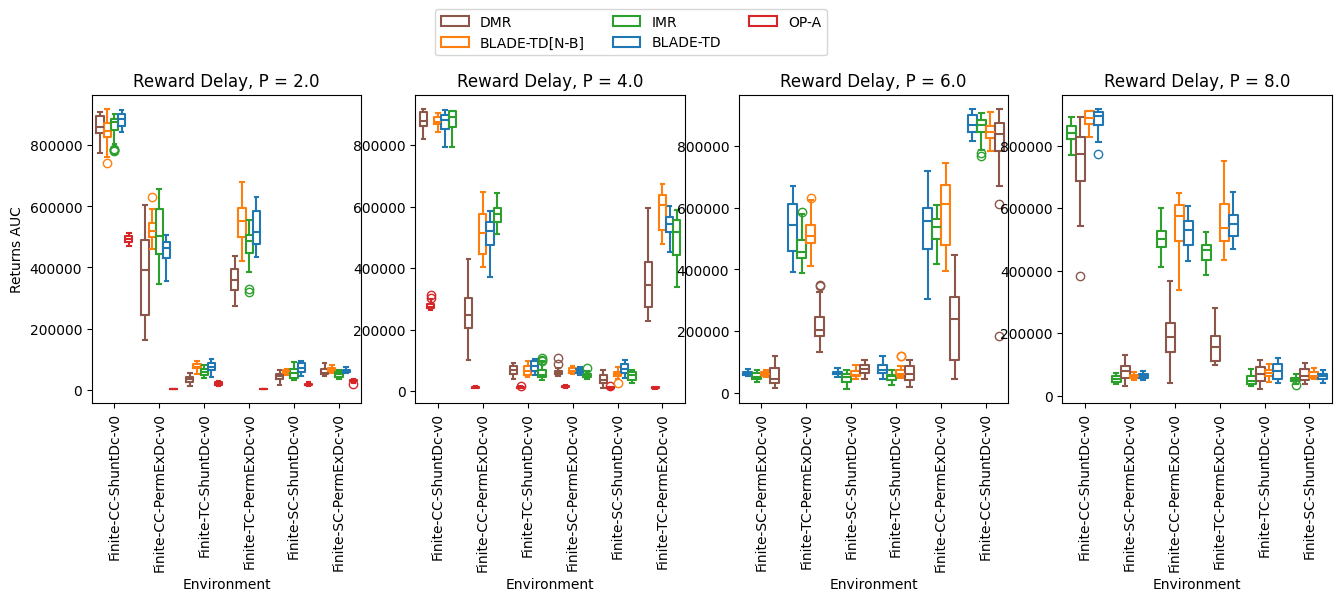

In [44]:
plot_auc(df_returns_auc)

## Time to Threshold Returns

In [45]:
def plot_delay_perf_curves(df_data, metric: str):
    df_raw = df_data[["env_name", "gamma", "delay_mu", "method", metric]]
    df_raw = copy.deepcopy(df_raw[df_raw["method"] != "FR"])
    palette = {key: pl for key, pl in METHODS_PALETTES.items() if key != "FR"}
    envs = sorted(df_raw["env_name"].unique())
    ncols = len(envs)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4))

    for env, ax in zip(envs, axes.flatten()):
        df_slice = df_raw[df_raw["env_name"] == env]
        sns.lineplot(
            data=df_slice,
            x="delay_mu",
            y=metric,
            hue="method",
            style="method",
            palette=palette,
            markers=True,
            dashes=False,
            ax=ax,
        )
        ax.set_title(env)

In [46]:
def calc_threshold_metrics(df_data, threshold: float = 0.9):
    fr_mask = df_data["method"] == "FR"
    df_fr = df_data[fr_mask]
    df_other = df_data[~fr_mask]

    rows = []
    # each row is a config: env x gamma x method x delay
    for row in df_other.to_dict("records"):
        # get baseline returns
        df_fr_slice = df_fr[
            (df_fr["env_name"] == row["env_name"]) & (df_fr["gamma"] == row["gamma"])
        ]
        fr_returns_matrix = np.stack(df_fr_slice.iloc[0]["runs_returns_matrix"])
        # returns at the last step
        fr_mean_returns_last_ep = np.mean(fr_returns_matrix[:, -1])
        method_returns_matrix = np.stack(row["runs_returns_matrix"])
        # Positive returns
        if fr_mean_returns_last_ep > 0:
            bound = threshold * fr_mean_returns_last_ep
        else:
            bound = (2 - threshold) * fr_mean_returns_last_ep
        # which episodic returns are above the treshold
        ep_above_threshold_mask = method_returns_matrix >= bound
        # which runs reach the threshold
        ep_that_reach_threshod_mask = np.sum(ep_above_threshold_mask, axis=1) > 0
        # first episode reaching threshold in each run
        first_ep_reaching_threshold = np.argmax(ep_above_threshold_mask, axis=1)
        # In runs reaching threshold, average episode
        mean_time_to_reach_threshold = np.mean(
            first_ep_reaching_threshold[ep_that_reach_threshod_mask]
        )
        # percentage of episodes tha reach threshold
        ep_that_reach_threshod = np.sum(ep_that_reach_threshod_mask) / len(
            ep_that_reach_threshod_mask
        )
        # time perce of episodes spent above threshold
        time_above_threshold = np.mean(
            np.sum(
                # use abs for negative returns
                ep_above_threshold_mask >= bound,
                axis=1,
            )
            / method_returns_matrix.shape[1]
        )
        # approx time spent within range of threshold
        # runs x episodes
        entry = copy.deepcopy(row)
        entry["mean_time_to_reach_threshold"] = mean_time_to_reach_threshold
        entry["perc_turns_reaching_threshold"] = ep_that_reach_threshod
        entry["time_above_threshold"] = np.mean(
            np.sum(
                # use abs for negative returns
                # TODO: check if pos or negative; differen top
                method_returns_matrix >= bound,
                axis=1,
            )
            / method_returns_matrix.shape[1]
        )
        rows.append(entry)
    return pd.DataFrame(rows)

In [47]:
def calc_env_method_return_perctile_ci(
    df_results: pd.DataFrame, confidence: float, decimals: int = 4
) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["method"].unique())

    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) & (df_results["method"] == method)
            ]
        )

        # across delays, gamma, and runs
        values = df_slice["time_above_threshold"].values
        ci_result, ci_fmt = calc_and_format_ci(
            values, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "method"])

In [48]:
df_threshold_metrics = calc_threshold_metrics(df_runs_returns)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
df_threshold_metrics.head()

,exp_id,runs_returns_matrix,runs_steps_matrix,env_name,gamma,method,meta,episodes,delay_type,delay_mu,mean_time_to_reach_threshold,perc_turns_reaching_threshold,time_above_threshold
0,1763120034-078ace44-Finite-SC-PermExDc-v0,"[[19.01418569316258, 2749.334785113375, 1469.6...","[[17, 114, 9, 885, 877, 2992, 59, 536, 7, 1738...",Finite-SC-PermExDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0,0.95,1.0,0.851
1,1763120034-0f495b0d-Finite-CC-ShuntDc-v0,"[[18897.154275046858, 5.526600685996535, 17869...","[[10000, 7, 10000, 10000, 10000, 10000, 10000,...",Finite-CC-ShuntDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0,0.65,1.0,0.856
2,1763120034-03297052-Finite-CC-ShuntDc-v0,"[[18740.864737448857, 6134.31168520065, 17863....","[[10000, 1009, 10000, 10000, 10000, 10000, 100...",Finite-CC-ShuntDc-v0,0.99,DMR,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,4.0,0.70,1.0,0.862
3,1763120034-0d58b89d-Finite-TC-PermExDc-v0,"[[52.84268983361375, 24.947187294036272, 38.68...","[[38, 28, 28, 10000, 9018, 10000, 933, 2048, 1...",Finite-TC-PermExDc-v0,0.99,BLADE-TD,"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,6.0,3.30,1.0,0.595
4,1763120034-0e4ea9b9-Finite-CC-PermExDc-v0,"[[28.67069320859558, 4693.250056473447, 17111....","[[25, 10000, 10000, 1456, 10000, 2895, 10000, ...",Finite-CC-PermExDc-v0,0.99,BLADE-TD[N-B],"{'context': {'dummy': 0}, 'exp_id': '176312003...","[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1...",clipped-poisson,2.0,5.65,1.0,0.425


In [50]:
calc_env_method_return_perctile_ci(df_threshold_metrics, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


method,BLADE-TD,BLADE-TD[N-B],DMR,IMR,OP-A
env_name,,,,,
Finite-CC-PermExDc-v0,0.4911 ± 0.0794,0.5535 ± 0.0734,0.2324 ± 0.0872,0.524 ± 0.1636,0.0 ± nan
Finite-CC-ShuntDc-v0,0.9125 ± 0.0394,0.88 ± 0.0556,0.8421 ± 0.0642,0.8979 ± 0.0562,0.007 ± 0.0118
Finite-SC-PermExDc-v0,0.824 ± 0.0728,0.8481 ± 0.0602,0.5798 ± 0.1039,0.3932 ± 0.1843,0.0513 ± 0.0527
Finite-SC-ShuntDc-v0,0.3719 ± 0.2431,0.3326 ± 0.2511,0.2805 ± 0.223,0.3242 ± 0.1771,0.0282 ± 0.0255
Finite-TC-PermExDc-v0,0.5866 ± 0.0645,0.6019 ± 0.0663,0.1889 ± 0.1003,0.3931 ± 0.1648,0.0 ± nan
Finite-TC-ShuntDc-v0,0.3127 ± 0.2209,0.3223 ± 0.2533,0.2535 ± 0.2153,0.2611 ± 0.1818,0.0258 ± 0.0294


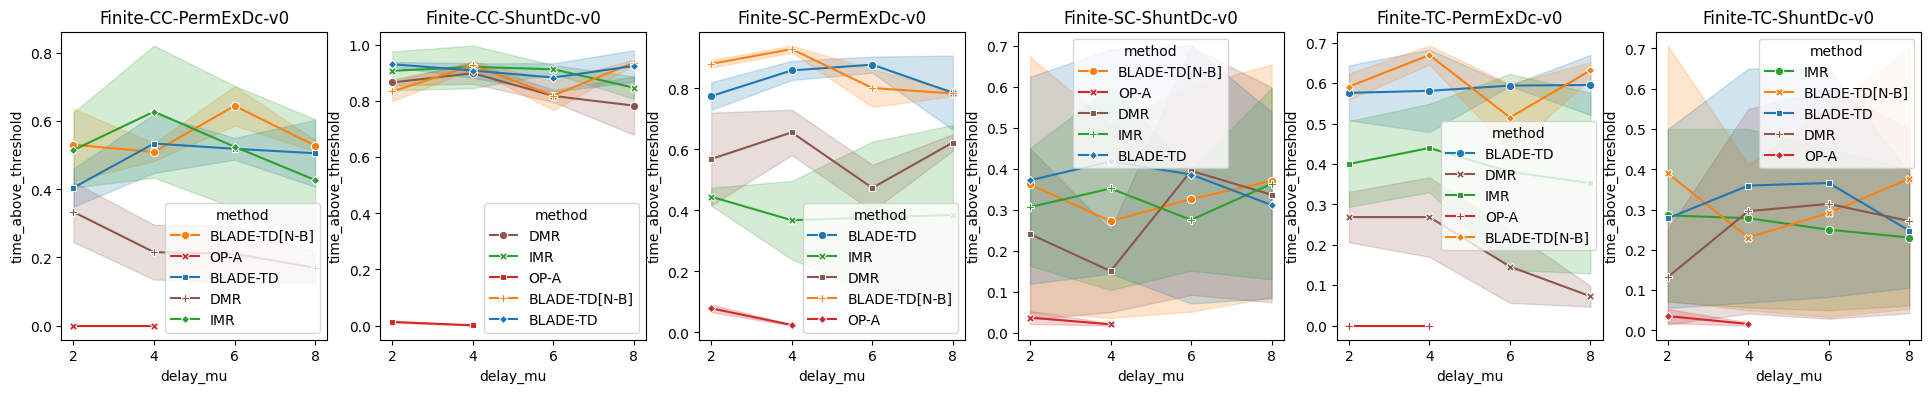

In [51]:
plot_delay_perf_curves(df_threshold_metrics, "time_above_threshold")

Most of these environments have high variance in their starts, or get worse before they get good.
Measuring time to reach a threshold result is unreliable.

## Method Efficiency per Delay

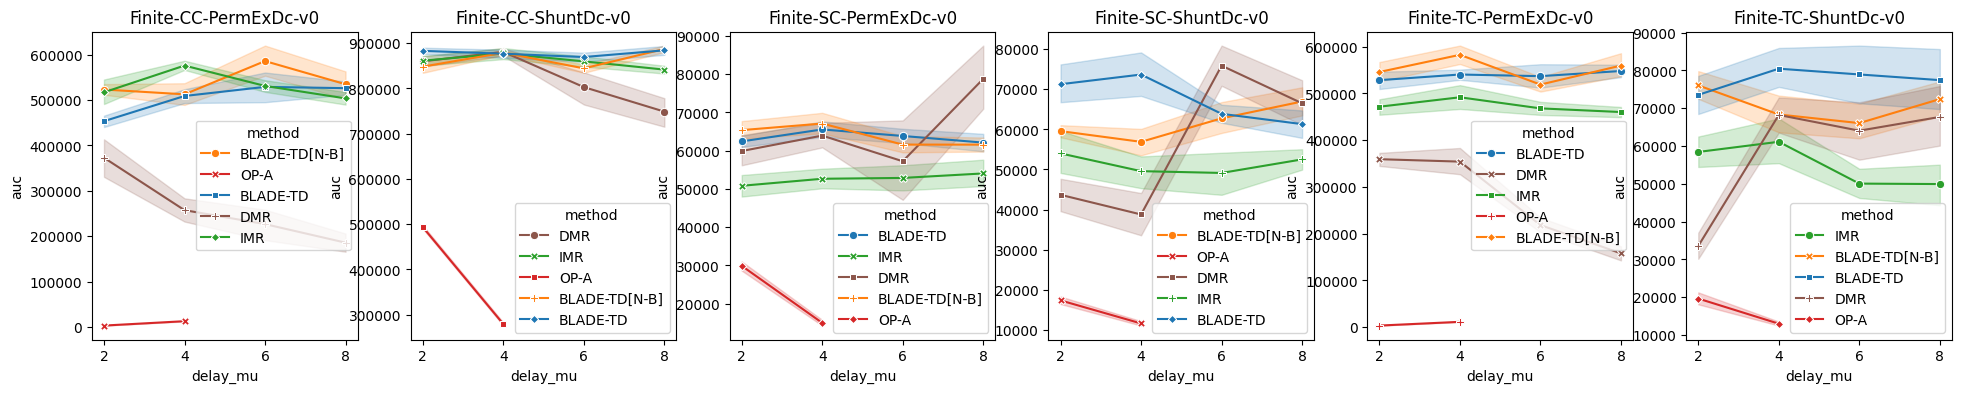

In [52]:
plot_delay_perf_curves(df_returns_auc.explode("auc").reset_index(), metric="auc")

## Returns Interquartile Mean @ K (IQM@K)

In [53]:
def calc_returns_iqm(df_data, confidence: float, decimals: int = 4):
    def calc_iqm_returns(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        runs_returns = runs_returns_matrix[:, -1]
        return stats.trimboth(runs_returns, proportiontocut=0.25)

    df_raw = copy.deepcopy(df_data)
    df_raw["iqm_returns"] = df_raw["runs_returns_matrix"].apply(calc_iqm_returns)

    envs = sorted(df_raw["env_name"].unique())
    methods = sorted(df_raw["method"].unique())
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = df_raw[(df_raw["env_name"] == env) & (df_raw["method"] == method)]
        # across delays, gamma, and runs
        values = np.stack(df_slice["iqm_returns"]).flatten()
        ci_result, ci_fmt = calc_and_format_ci(
            values, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)

    return pd.DataFrame(rows)

In [54]:
calc_returns_iqm(df_runs_returns, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)

method,BLADE-TD,BLADE-TD[N-B],DMR,FR,IMR,OP-A
env_name,,,,,,
Finite-CC-PermExDc-v0,12640.1155 ± 437.4756,12967.7152 ± 447.9476,6541.7356 ± 781.7922,12159.9243 ± 805.948,12313.2072 ± 228.6035,319.008 ± 80.1834
Finite-CC-ShuntDc-v0,18216.7564 ± 27.3351,18173.5307 ± 38.1065,18673.8287 ± 194.8455,18274.1557 ± 59.7214,17539.2619 ± 137.0658,7921.6751 ± 581.1591
Finite-SC-PermExDc-v0,1240.4547 ± 9.3417,1239.8629 ± 8.7338,1142.5879 ± 48.3366,1253.7771 ± 15.7116,1099.1815 ± 29.7707,197.7176 ± 18.1786
Finite-SC-ShuntDc-v0,2016.0175 ± 178.3071,1852.7017 ± 151.1055,815.7764 ± 137.9446,2169.2518 ± 449.9285,1804.335 ± 303.9047,92.2405 ± 6.1635
Finite-TC-PermExDc-v0,13276.3025 ± 338.4126,13247.4831 ± 377.7508,9094.2865 ± 617.8364,12767.5306 ± 869.48,11869.2644 ± 211.5866,239.6076 ± 54.6789
Finite-TC-ShuntDc-v0,3009.4092 ± 390.3321,2607.4166 ± 307.2699,761.6318 ± 147.4294,3450.7253 ± 992.9275,1960.0328 ± 363.1701,107.489 ± 8.6803


## Returns Running Coefficient of Variation (CV)

In [55]:
def calc_returns_cv(
    df_data, confidence: float, decimals: int = 4, window_size: int = 5
):
    def calc_rolling_cv(sequence):
        # Convert to pandas series for easy rolling ops
        series = pd.Series(sequence)
        # CV = Rolling Std / Rolling Mean
        res = series.rolling(window_size).std() / series.rolling(window_size).mean()
        return res.fillna(0).values

    def returns_cv(runs_returns_matrix):
        runs_returns_matrix = np.stack(runs_returns_matrix)
        rows = []
        for i in range(runs_returns_matrix.shape[0]):
            row = calc_rolling_cv(runs_returns_matrix[i])
            rows.append(np.mean(row))
        return np.array(rows)

    df_raw = copy.deepcopy(df_data)
    df_raw["returns_rolling_cv"] = df_raw["runs_returns_matrix"].apply(returns_cv)

    envs = sorted(df_raw["env_name"].unique())
    methods = sorted(df_raw["method"].unique())
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = df_raw[(df_raw["env_name"] == env) & (df_raw["method"] == method)]
        # across delays, gamma, and runs
        values = np.stack(df_slice["returns_rolling_cv"]).flatten()
        ci_result, ci_fmt = calc_and_format_ci(
            values, confidence=confidence, decimals=decimals
        )
        row = {"env_name": env, "method": method, "ci_fmt": ci_fmt, **ci_result}
        rows.append(row)
    return pd.DataFrame(rows)

In [56]:
calc_returns_cv(df_runs_returns, confidence=0.95).pivot(
    columns="method", index="env_name", values="ci_fmt"
)

method,BLADE-TD,BLADE-TD[N-B],DMR,FR,IMR,OP-A
env_name,,,,,,
Finite-CC-PermExDc-v0,0.4081 ± 0.0162,0.3527 ± 0.0131,0.9996 ± 0.0355,0.3358 ± 0.0131,0.3335 ± 0.0132,0.1857 ± 0.0268
Finite-CC-ShuntDc-v0,0.0624 ± 0.0073,0.0802 ± 0.0086,0.1996 ± 0.0295,0.0541 ± 0.0199,0.0554 ± 0.0076,0.0846 ± 0.0112
Finite-SC-PermExDc-v0,0.1502 ± 0.0077,0.1361 ± 0.0094,0.5755 ± 0.0467,0.0678 ± 0.0045,0.2969 ± 0.0148,0.2648 ± 0.0162
Finite-SC-ShuntDc-v0,0.3117 ± 0.0165,0.3702 ± 0.0195,0.9438 ± 0.043,0.2328 ± 0.0279,0.7783 ± 0.0288,0.236 ± 0.0212
Finite-TC-PermExDc-v0,0.3184 ± 0.0114,0.2905 ± 0.0094,0.7737 ± 0.0377,0.3012 ± 0.0225,0.3304 ± 0.0141,0.2313 ± 0.0338
Finite-TC-ShuntDc-v0,0.4121 ± 0.0192,0.4625 ± 0.0228,1.0048 ± 0.0424,0.2876 ± 0.0537,0.8344 ± 0.0291,0.2274 ± 0.0232


## For Print

### Relative Regret - Returns Ratio

In [57]:
def print_regret(
    df_data, suffix=None, method_filter_fn=lambda met: True, output_dir="figures/regret"
):
    df_raw = copy.deepcopy(
        df_data[["env_name", "method", "delay_type", "delay_mu", "relative_regret"]]
    )
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]
    if len(df_raw) == 0:
        return
    rps = sorted(df_raw["delay_mu"].unique())

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for rp in rps:
        df_plot = df_raw[df_raw["delay_mu"] == rp]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(
            df_plot,
            x="env_name",
            y="relative_regret",
            hue="method",
            palette=METHODS_PALETTES,
            ax=ax,
            fill=False,
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Returns Ratio")
        ax.set_title(f"Reward Period, P = {rp}")
        name = f"regret_{suffix}_rp{rp}.pdf"
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches="tight")

In [58]:
print_regret(
    filter_envs(
        dfs_regret["sarsa"],
        envs=set(["GridWorld-v0", "IceWorld-v0", "MountainCar-v0", "RedGreen-v0"]),
    ),
    suffix="gym_sarsa",
)

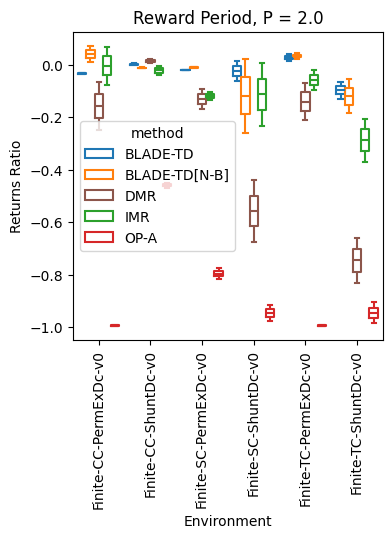

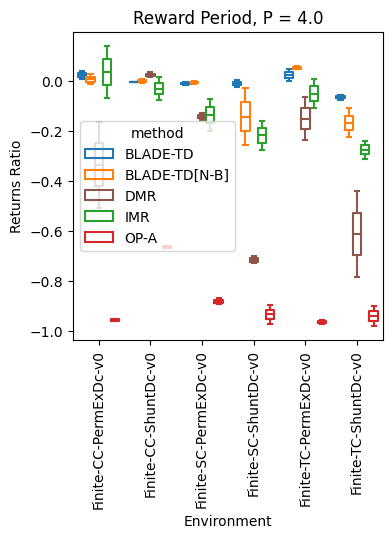

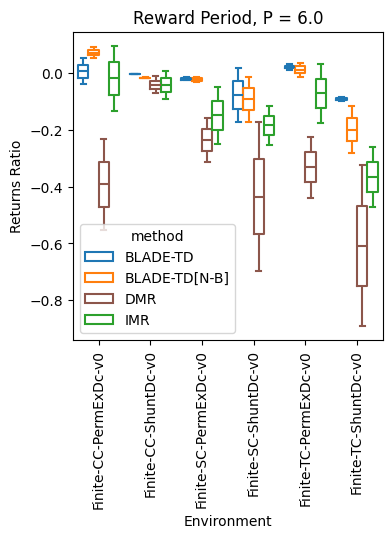

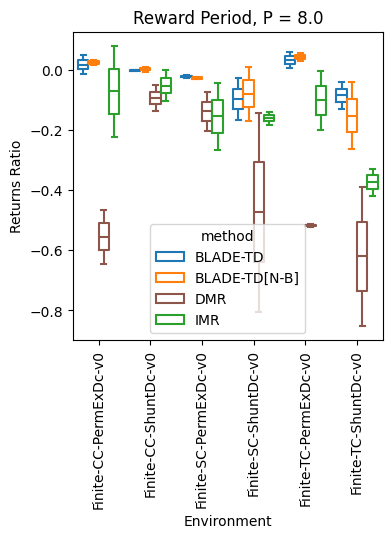

In [59]:
print_regret(
    filter_envs(
        dfs_regret["sarsa"],
        envs=set(
            [
                "Finite-CC-PermExDc-v0",
                "Finite-CC-ShuntDc-v0",
                "Finite-SC-PermExDc-v0",
                "Finite-SC-ShuntDc-v0",
                "Finite-TC-PermExDc-v0",
                "Finite-TC-ShuntDc-v0",
            ]
        ),
    ),
    suffix="gem_sarsa",
)

### Regret per Env

In [60]:
def plot_regret_dist(df_data, suffix, output_dir="figures/regret"):
    env_names = sorted(df_data["env_name"].unique())
    for env_name in env_names:
        df_slice = df_data[df_data["env_name"] == env_name]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.kdeplot(
            data=df_slice,
            x="relative_regret",
            hue="method",
            palette=METHODS_PALETTES,
            fill=False,
            ax=ax,
        )
        ax.set_xlabel("Returns Ratio")
        ax.set_ylabel("Density")
        ax.set_title(f"Environment = {env_name}")
        name = f"regret_{suffix}_env_{env_name}.pdf"
        path = os.path.join(output_dir, name)
        plt.savefig(path, dpi=300, format="pdf", bbox_inches="tight")

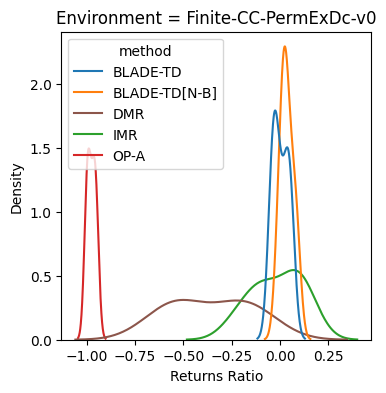

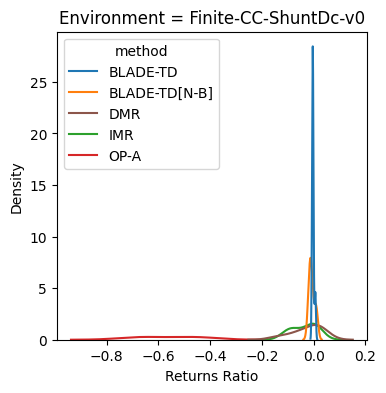

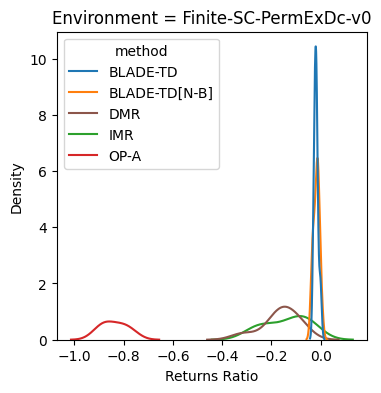

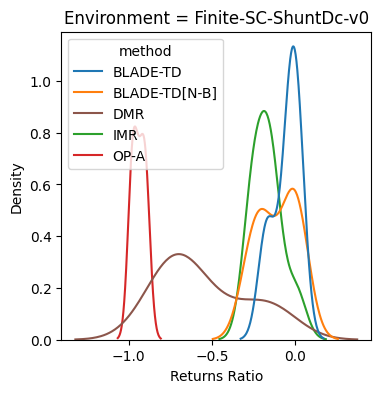

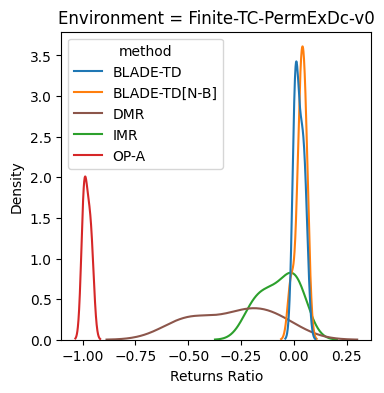

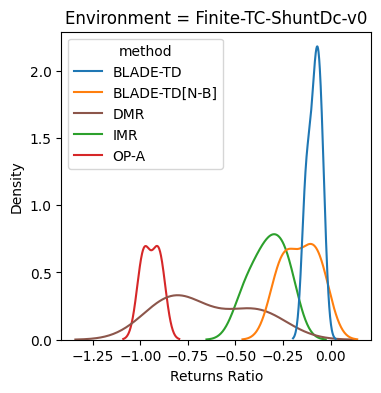

In [61]:
plot_regret_dist(dfs_regret["sarsa"], "sarsa")